# pySCENIC on NK cells, MM

Preparation and run Single-Cell rEgulatory Network Inference and Clustering using pySCENIC.

## Why pySCENIC
- A lot of compatibility problems with the R version
- Faster
- I like more python than

After having preparred the environment and the files (look [here](./prepare_env.ipnb))

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [2]:
adata = sc.read_h5ad("Data/75/mm_nk_processed.h5ad")
adata = adata[adata.obs["new_label"] != "Others"]
adata

View of AnnData object with n_obs × n_vars = 3519 × 48361
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'batch', 'label', 'new_label', 'condition'

In [3]:
#sc.pp.subsample(adata, n_obs=100)

write to an unfiltered loom file

In [4]:
f_loom_path_unfilt = "Data/75/nk_mm_75_unfiltered.loom"
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
    "new_label": np.array(adata.obs.new_label)
}

lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )

# basic metrics and filtering:

In [5]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info~
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  911589.0
Number of cells in which each gene is detected: 0  -  3517


In [6]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  105.57
minSamples:  35.19


In [7]:
adata_copy = adata.copy()

# initial cuts
sc.pp.filter_cells(adata_copy, min_genes=200 )
sc.pp.filter_genes(adata_copy, min_cells=minSamples)
sc.pp.filter_genes(adata_copy, min_counts=minCountsPerGene)

adata_copy

AnnData object with n_obs × n_vars = 3515 × 8544
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'batch', 'label', 'new_label', 'condition', 'n_genes'
    var: 'n_cells', 'n_counts'

In [8]:
f_loom_path_scenic = "Data/75/nk_mm_75_scenic.loom"

In [9]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata_copy.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata_copy.obs_names) ,
    "nGene": np.array( np.sum(adata_copy.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata_copy.X.transpose() , axis=0)).flatten() ,
    "new_label": np.array(adata_copy.obs.new_label)

}
lp.create( f_loom_path_scenic, adata_copy.X.transpose(), row_attrs, col_attrs)

## Scenic


### STEP 1: Gene regulatory network inference, and generation of co-expression modules
Phase Ia: GRN inference using the GRNBoost2 algorithm

For this step the CLI version of SCENIC is used.


In [10]:
tfs = "databases/allTFs_hg38.txt"

In [11]:
!mkdir Results/75/

mkdir: cannot create directory 'Results/75/': File exists


Dask is having memory issues using all the cores available (24), testing with less nodes (12) ([reference](https://github.com/aertslab/pySCENIC/issues/54#issuecomment-817164063)). If it doesn't work I'll try the multiprocessing script:
```
! arboreto_with_multiprocessing.py \
    {f_loom_path_scenic} \
    {tfs} \
    --method grnboost2 \
    --output Results/adj.tsv \
    --num_workers 24 \
    --seed 123
```

`pyscenic grn` with less workers worked (half of the cpus available)

In [12]:
! arboreto_with_multiprocessing.py \
    {f_loom_path_scenic} \
    {tfs} \
    --method grnboost2 \
    --output Results/75/adj_mm_75.csv \
    --num_workers 24 \
    --seed 123 1> Results/75/arboreto_mm.log 2> Results/75/arboreto_mm.err

In [13]:
#!pyscenic grn {f_loom_path_scenic} {tfs} -o Results/adj_mm.csv --num_workers 12 --seed 123 1> grn.log 2> grn.err

In [14]:
adjacencies = pd.read_csv("Results/75/adj_mm_75.csv", index_col=False)
adjacencies.head()

,TF,target,importance
0,TPI1,ENO1,169.774547
1,ZNF90,ATP5E,154.521655
2,ZNF90,GNB2L1,142.048628
3,ENO1,GAPDH,138.286925
4,ENO1,TPI1,134.009440


### STEP 2-3: Regulon prediction aka cisTarget from CLI

In [15]:
import glob
# ranking databases
f_db_glob = "databases/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "databases/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl"

Evaluate co-expressio modules infering TF motifs:

v

In [16]:
!pyscenic ctx Results/75/adj_mm_75.csv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output Results/75/reg_mm.csv \
    --mask_dropouts \
    --num_workers 24 \
    1> Results/75/ctx_mm.log 2> Results/75/ctx_mm.err

In [17]:
!tail Results/75/ctx_mm.err


2023-06-06 17:53:24,576 - pyscenic.prune - INFO - Worker hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings(3): All regulons derived.

2023-06-06 17:53:24,576 - pyscenic.prune - INFO - Worker hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings(3): All regulons derived.

2023-06-06 17:53:24,586 - pyscenic.prune - INFO - Worker hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings(3): Done.

2023-06-06 17:53:24,586 - pyscenic.prune - INFO - Worker hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings(3): Done.

2023-06-06 17:53:24,752 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [18]:
nGenesDetectedPerCell = pd.DataFrame(np.sum(adata_copy.X>0, axis=1).flatten().tolist()).T
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, .9, 1])
print(percentiles)

           0
0.01   323.7
0.05   524.7
0.10   633.4
0.50  1362.0
0.90  2154.0
1.00  4794.0


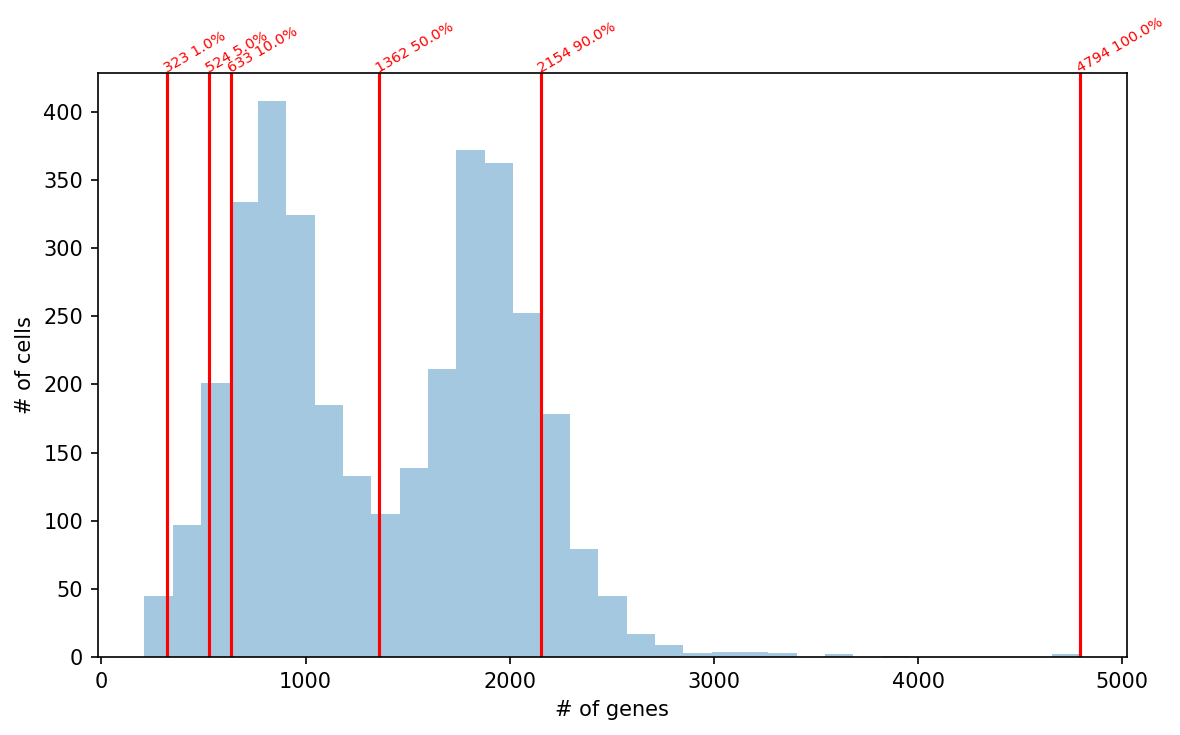

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in percentiles.iterrows():
    fig.gca().axvline(x=x[0], ymin=0,ymax=1, color='red')
    ax.text(x=x[0], y=ax.get_ylim()[1], s=f'{int(x[0])} {i*100}%', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [20]:
f_pyscenic_output = "Results/75/pyscenic_output_mm.loom"

In [21]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    Results/75/reg_mm.csv \
    --output {f_pyscenic_output} \
    --auc_threshold 0.1 \
    --num_workers 24 \
     1> aucell_mm_exh.log 2> aucell_mm_exh.err

In [22]:
!tail aucell_mm_exh.err


2023-06-06 17:53:31,681 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-06-06 17:53:32,154 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.

2023-06-06 17:53:34,036 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2023-06-06 17:53:46,301 - pyscenic.cli.pyscenic - INFO - Writing results to file.
/home/jacopo/scenic/.venv/lib/python3.8/site-packages/pyscenic/cli/utils.py:347: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, threshold in auc_thresholds.iteritems()


In [23]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [24]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "Results/75/scenic_umap_mm.txt", sep='\t')

In [25]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'Results/75/scenic_umap_mm.txt', sep='\t', header=0, index_col=0 )
###

In [26]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

# TODO: continue with saving the file, adding the umap coordinates to the anndata object, analysis

In [27]:
Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1']

In [28]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": 1,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["new_labels"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy new_labels",
            "label": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "new_label",
        "values": list(set( adata.obs['new_label'].astype(np.str) ))
    },
    #{
    #    "name": "Genotype",
    #    "values": list(set(adata.obs['Genotype'].values))
    #},
    #{
    #    "name": "Timepoint",
    #    "values": list(set(adata.obs['Timepoint'].values))
    #},
    #{
    #    "name": "Sample",
    #    "values": list(set(adata.obs['Sample'].values))
    #}
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(len(adata.obs["new_label"].values.categories) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['new_labels'][0]['label'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata_copy.obs['new_label'].values

In [29]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [30]:
col_attrs = {
    "CellID": np.array(adata_copy.obs.index),
    "nUMI": np.array(adata_copy.obs['nCount_RNA'].values),
    "nGene": np.array(adata_copy.obs['nFeature_RNA'].values),
    "batch": np.array( adata_copy.obs['batch'].values ),
    #"Genotype": np.array(adata_copy.obs['Genotype'].values),
    #"Timepoint": np.array(adata_copy.obs['Timepoint'].values),
    #"Sample": np.array(adata_copy.obs['Sample'].values),
    "percent_mt": np.array(adata_copy.obs['percent_mt'].values),
    "label": np.array(adata_copy.obs['label'].values),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "new_label": np.array(adata_copy.obs['new_label'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'hg38',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

In [31]:
f_final_loom = "Results/75/mm_scenic_integrated-output.loom"
lp.create(
    filename = f_final_loom ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file